# Cepheid light curve analysis and the distance to the LMC

*Author: Aaron Geller* <br/> *June 2018*

### First, some background...

<i>[Cepheids are variable stars](https://en.wikipedia.org/wiki/Classical_Cepheid_variable) that have regular radial pulsations, and therefore brightness variations with periods of a few days to a few weeks. They are 4–20 times more massive than the Sun, and are in the giant evolutionary phase.

Perhaps the most important feature of a Cepheid is that the period of its pulsations is correlated with its intrinsic luminosity.  This allows us to measure the distance to any Cepheid, simply by measuring the pulsation period and  apparent magnitude.  Cepheids are an important rung on the [cosmic distance ladder](https://en.wikipedia.org/wiki/Cosmic_distance_ladder).

[The Optical Gravitational Lensing Experiment (OGLE)](http://ogle.astrouw.edu.pl/) is a time-series photometry survey that has [observed many Cepheids](http://ogle.astrouw.edu.pl/atlas/classical_Cepheids.html) in our neighboring Galaxy the [Large Magellanic Cloud (LMC)](https://en.wikipedia.org/wiki/Large_Magellanic_Cloud).

In this workshop we will use [Cepheid observations from OGLE](http://ogledb.astrouw.edu.pl/~ogle/CVS/) to measure the distance to the LMC.
</i>


### Import libraries 

In [1]:
#import pandas as pd
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from astropy.io import ascii

%matplotlib inline

### Download data from the OGLE Cepheid database

*Go to the [OGLE archive](http://ogledb.astrouw.edu.pl/~ogle/CVS/).  On the left frame, click on "Classical Cepheids".  Then on the query page enter the following:*  




|**Parameter**| **Value/Range** ||
|:----------|:--------:|:---:|
| **RA**   |   5:12:31 | r60 |
| **Decl** | -69:12:31 |     |
| **Mode** | F         |     |


*Then click "Submit Query".  Note: you may have to type these values in rather than copy and paste.  This should bring up a page that has a link to the star called "OGLE-LMC-CEP-1240".  Download the I-band photometry and save this to a file on your computer.*

*Use ascii.read to read in this file, and get the date, magnitude and magnitude uncertainty.*

In [2]:
#filename = -
#lc = pd.read_csv(-)
datafile = ascii.read('data/OGLE-LMC-CEP-1240.dat')

jd = datafile['col1']
mag = datafile['col2']
mag_unc = datafile['col3']


### Plot the time-series data

* *Use [matplotlib.pyplot.errorbar](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.errorbar.html) to plot the time vs. magnitude, showing the uncertainties on magnitude.*
* *Label your axes.*
* *And remember to make the brightness increase toward the top of your plot!*

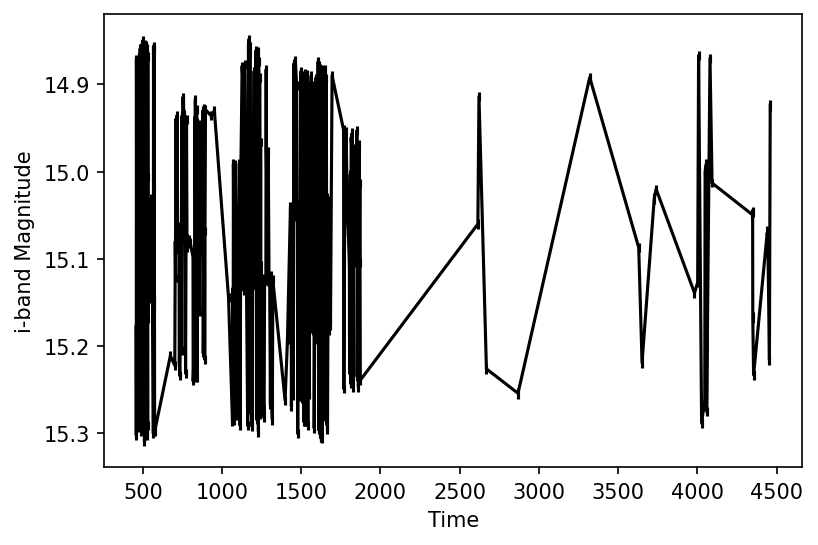

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
ax.errorbar(jd, mag, yerr=mag_unc, color='k')#, marker='*')
ax.set_xlabel('Time')
ax.set_ylabel('i-band Magnitude')
ax.invert_yaxis()
plt.show()

## Calculate and plot the Lomb Scargle periodogram

### [Lomb Scargle](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis#The_Lomb%E2%80%93Scargle_periodogram) period analyses essentially fit a sine curve to the data, testing different frequencies, and return the overlap between the model and data (called the "power") at each frequency as a measure of goodness of fit.  The higher the power, the better the frequency matches the data.

We will use [astropy.timeseries.LombScargle](https://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html).  Here, the frequency is 1/period, in units of days.

* Run the Lomb Scargle analysis.
* Print the period at the highest power (i.e., the best period; hint, you can use [numpy.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) to find the index of the maximum value in an array). 
* Plot the periodogram (period or frequency vs. power), and mark the best period on your plot.
</i>

best period = 3.9956361273784324
best frequency =  0.25027303991670224


Text(0, 0.5, 'Power')

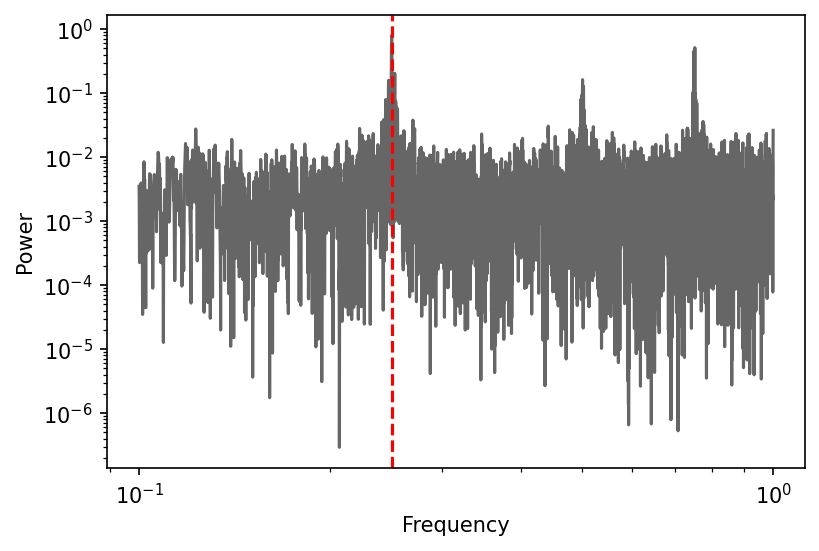

In [4]:
pmin = 1
pmax = 10
ls = LombScargle(jd, mag, mag_unc)
frequency, power = ls.autopower(maximum_frequency=1./pmin, minimum_frequency=1./pmax)
best_frequency = frequency[np.argmax(power)]

#calculate the best period and print it
period = 1/frequency
best_period = 1/best_frequency
print('best period =', best_period)
print('best frequency = ', best_frequency)

#plot the periodogram
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
#ax.errorbar(jd, mag, yerr=mag_unc, color='k')
ax.plot(frequency, power, 'k', alpha=0.6)
ax.axvline(best_frequency, color='r', linestyle='--')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')

### Plot the phased light curve

*Once the period is determined, it is often helpful to plot the phased light curve.  In other words, we want to fold all the data on the best period.  If the period we derived is indeed the correct period for the system, this phased plot should show all the data lining up along the characteristic shape of a Cepheid variable.*

*To calculate the phase, take the observation date modulo the best period, then divide that by the best period.  This should give you a phase from zero to one.*

*Plot the phase vs. magnitude, and show the magnitude uncertainties as well.  Again, label your axes, and keep the brightness increasing upwards.*

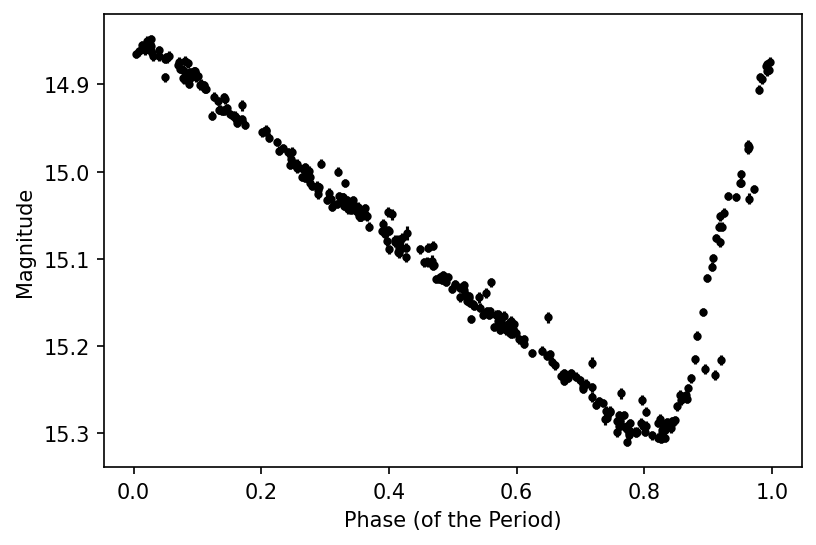

In [5]:
phase = ( jd % best_period ) / best_period

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
ax.errorbar(phase, mag, mag_unc, color='k', fmt='.')
ax.invert_yaxis()
ax.set_xlabel('Phase (of the Period)')
ax.set_ylabel('Magnitude')
plt.show()

## Now we will calculate the distance to the LMC

### First, use the Cepheid period-luminosity relations to estimate the absolute magnitude in the I band.

Cepheids are known to show a relation between the pulsation period and the intrinsic luminosity (or absolute magnitude).  We will use the equation from [here](http://adsabs.harvard.edu/abs/2007AJ....133.1810B):

$$
M = a + b\left(\log_{10} P -1.00\right)
$$ 

*From their Table 12:*

$$
a_I = -4.78 \pm 0.03\\ 
b_I = -2.81 \pm 0.11
$$

*Use this formula to estimate the absolute magnitude of this Cepheid.*

In [7]:
def cepheid_absmag(period):
    a1 = -4.78
    b1 = -2.81
    return(a1 + b1*(np.log10(period) - 1.0))

abs_mag = cepheid_absmag(best_period)
print(abs_mag)

-3.6604564667812194


### Next, estimate the apparent magnitude, corrected for extinction

*First, we need to get a single number for the observed (i.e., apparent) magnitude.  A simple way to do this is to take the mean of the observed magnitudes.  (A more correct way would be to fit the light curve and take the zero-point value from the fit, but we won't go that deep here.)*

*Let's call this mean magnitude $I$, and now we want to correct this for extinction to get $I_0$.  We will use the usual formula:*

$$
I_0 = I - A_I 
$$
$$
A_I/A_V = 0.479
$$

*where, $A_\lambda$ is the color index (see [Allen's Astrophysical Quantities](https://books.google.com/books/about/Allen_s_Astrophysical_Quantities.html?id=w8PK2XFLLH8C) ).  And let's take*

$$
A_V = 0.52
$$

*as they do in [the reference we used above for the period-luminosity relation](http://adsabs.harvard.edu/abs/2007AJ....133.1810B).*

*Calculate $I_0$ below.*


In [9]:
def cepheid_appmag(mag):
    mean_app_uncorrected = np.mean(mag)
    AV = 0.52
    AI = 0.479*AV
    app_mag = mean_app_uncorrected - AI
    return(app_mag)
    
app_mag = cepheid_appmag(mag)
print(app_mag)

14.831148412256267


### Now, estimate the distance to the LMC using the distance modulus

*The [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) is defined as :*

$$
m - M = 5\log d - 5
$$

*where $m$ is the apparent magnitude ($I_0$ here), $M$ is the absolute magnitude (calculated above), and $d$ is the distance in parsecs.*

*Calculate the distance to the LMC derived from this Cepheid below.*

In [101]:
# formula: app_mag - abs_mag = 5*log10(d) - 5
d0 = 10**((app_mag - abs_mag + 5)/5)
print(d0/1000)

49.92533363548966


### The LMC is at a distance of about 50 kpc

*Hopefully that is also roughly what you found above.  If not... check your math.* 

# Uncertainty on our distance measurement

*How would we estimate the uncertainty on this measurement?*

*One way would be to propagate the uncertainties through from the fit and the observed magnitudes.  I encourange you to try this after we complete this tutorial.*

*But first, a complimentary way to estimate the uncertainty would be to grab a bunch of Cepheids so that we can figure out the scatter.*

*Go back to the OGLE database and grab a bunch of Cepheids.  (Hint: you can use a similar query that we used above, but increase the search radius – e.g., replace 'r60' with 'r6000' – then download the full photometry files in tar.gz format.)  Then calculate their distances using the same procedure as above.  I recommend defining a method that takes a file as input and returns a distance.*

In [102]:
def getDistance(filename, pmin=1, pmax=10):
    datafile = ascii.read('data/'+str(filename))
    #datafile
    jd, mag, err = datafile['col1'], datafile['col2'], datafile['col3']
    
    #get the period
    ls = LombScargle(jd, mag, err)
    frequency, power = ls.autopower(maximum_frequency=1./pmin, minimum_frequency=1./pmax)
    best_frequency = frequency[np.argmax(power)]
    period = 1/frequency
    best_period = 1/best_frequency

    #get the absolute magnitude
    abs_mag = cepheid_absmag(best_period)
    #get the apparent magnitude, corrected for reddening as above
    app_mag = cepheid_appmag(mag)
    
    #estimate the distance in kpc
    d = (10**((app_mag - abs_mag + 5)/5)/1000)
    #return the distance
    return(d)#* u.parsec)

In [103]:
#use the method you created to get the distance to all the Cepheids you downloaded
ogle_filenames = ascii.read('filenames.txt')

d = []
for name in ogle_filenames['names']:
    d.append(getDistance(name))
d = np.array(d)

### Plot a histogram of these distance values.
Instead of the line only saying "ax.hist" to plot, you can use ax.hist to also return information *about* the histogram, like the bin values ("b) and the height in each bin ("h"), as well as the image for the plot itself ("im"). To keep all that information, we can write "h,b,im = ax.hist(---)".

Hint: You may also wish to convert the number in each bin to a total percentage of values per bin. You can do this manually, but it can also be done for you by setting "density=True" in the ax.hist line.

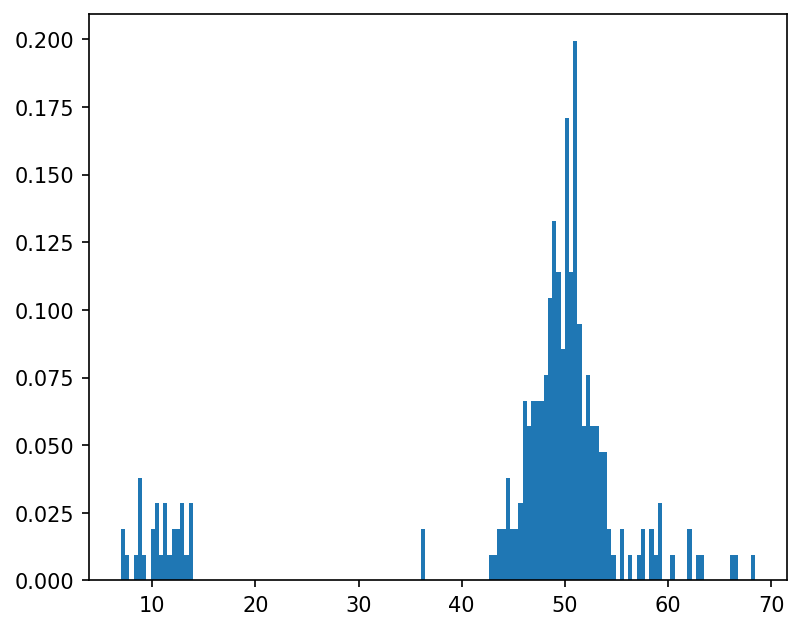

In [118]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=150)
h, b, im = ax.hist(d, bins=150, density=True)
plt.show()

*We want to quote a single distance and an uncertainty on that distance for the LMC.  How should we do this?*

### Calculate the mean and standard error

*One method could be to calculate the mean of this distribution of distances and the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).  Do this below, and, for practice, print it using [f-strings](https://www.blog.pythonlibrary.org/2018/03/13/python-3-an-intro-to-f-strings/) and showing only two digits after the decimal.*

In [119]:
mean_dist = np.mean(d)
std_dist = np.std(d)/np.sqrt(len(d))

print('d = %.2f +/- %.2f' %(mean_dist, std_dist))

d = 45.77 +/- 0.83


### Or, fit a Gaussian function to the distance distribution

*Another way that you might derive the distance and an error is to fit a [Guassian function](https://en.wikipedia.org/wiki/Gaussian_function) to this distribution (which is  what you assumed implicitly above by calculating a standard deviation and mean to describe the distribution).*

* *Fit this distribution with a Guassian function using [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).*
* *Plot the fit on top of the histogram.*


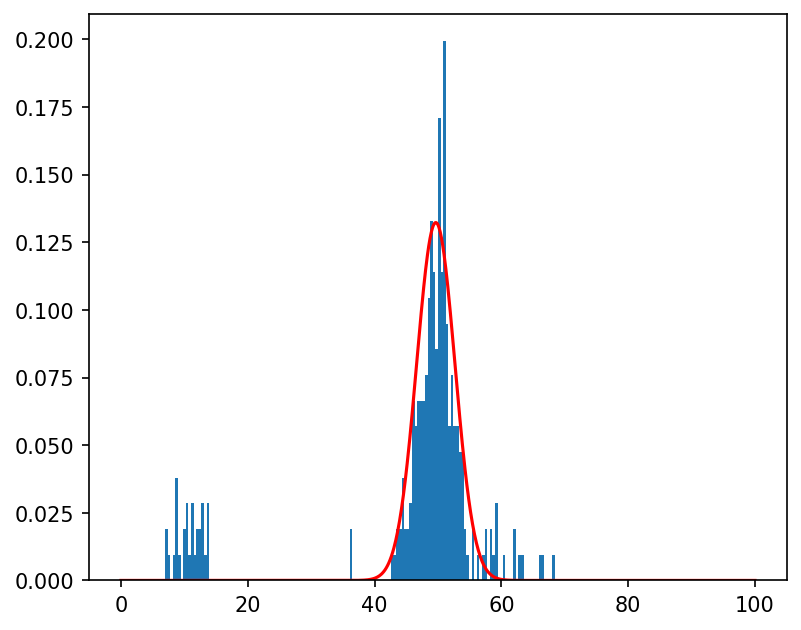

In [121]:
def gauss(x, mu, sigma):
    return 1./(sigma*(2.*np.pi)**0.5)*np.exp(-0.5*((x - mu)/sigma)**2.)

popt, pcov = curve_fit(gauss,b[:-1],h, p0=[mean_dist, std_dist])
err = np.sqrt(np.diag(pcov))

#plot the histogram again
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=150)
ax.hist(d, bins=150, density=True)

#plot the fit on top
xs = np.linspace(0, 100, 1000)
ax.plot(xs, gauss(xs, *popt), 'r')

*Now print the resulting mean and error on the fitted mean value.  Also print the fitted $\sigma$ value and error.  (Hint: see the documentation for curve_fit, linked above, on how to convert the covariance matrix into an uncertainty.*

In [124]:
print('%.2f +/- %.2f' %(popt[0], err[0]))

49.66 +/- 0.13


## Take-away questions

*Which of these distance values would you quote in a paper?  At least for me, the fit has a smaller error than the standard error on the mean; why?*

*How do you interpret the $\sigma$ value from your fit to the LMC distance distribution?*

*If you have outliers, why do you think that is?  (One hint: do all the Cepheids obey the period-luminosity relation we used?)  Could you improve your sample, and therefore your fit?*

## Extension activities

*Repeat your analysis above for the SMC.* 

*Then try using RR Lyrae stars to get the distance to the LMC and SMC.*

# Bonus: Bokeh interactive plot

*[Bokeh](https://bokeh.pydata.org/en/latest/) is a python library that allows you to create interactive plots with widgets (e.g., sliders, buttons, dropdown menus, etc.) to allow you to interactively explore your data.  This can be a useful tool in many cases, and is relatively easy to code up.  I recommend you playing around with it!*

*Below is an example that will look at our initial Cephied light curve, and allow you to manipulate the period at which we phase fold the data.*

*(For this particular Cepheid, this may not be extremely useful because Lomb Scargle did a great job at identifying the period, but sometimes Lomb Scargle fails, and you may want to look at the phase-folded data from multiple peaks in the periodogram to determine which is truly the best-fit period of the system.)*

In [6]:
from bokeh.plotting import *
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, CustomJS, Slider, Column
from bokeh.events import DoubleTap

*This cell below controls whether the demo produces an html file, or simply runs in the notebook*

In [7]:
output_notebook() # run in the notebook
output_file("LC_Bokeh_Demo.html", title='LC Bokeh Demo') # produce an html file

Loading BokehJS ...

In [13]:
# create a column data source for the plots to share

# NOTE: this is using data that you would have created above :
# jd, phase, mag == date, phase, and I-band magnitude of the observations of OGLE-LMC-CEP-1240
# period, power == period and power from the Lomb Scargle periodogram for OGLE-LMC-CEP-1240
# best_period == the period at maximum power from the Lomb Scargle analysis
# If you named your variables differently, please change them below

# For the light curve
mmag = np.mean(mag) - mag
LC_source = ColumnDataSource(data=dict(hjd=jd, phase=phase, mag=mmag, ))

# For the periodogram
P_source = ColumnDataSource(data=dict(period=period, power=power,))

# For the best period
bpx = np.full(2, best_period)
bpy = np.array([0,np.max(power)])
BP_source = ColumnDataSource(data=dict(bpx=bpx, bpy=bpy))

# define the tools to include
TOOLS = "pan,wheel_zoom,box_zoom, reset"

# create the plots
rawLC = figure(tools=TOOLS, width=400, height=200, title=None)
rawLC.scatter('hjd', 'mag', source=LC_source, color='crimson')
rawLC.xaxis.axis_label = "Days"
rawLC.yaxis.axis_label = "Brightness"

phaseLC = figure(tools=TOOLS, width=400, height=200, title=None)
phaseLC.scatter('phase', 'mag', source=LC_source, color='crimson')
phaseLC.xaxis.axis_label = "Phase"
phaseLC.yaxis.axis_label = "Brightness"

pdgm = figure(tools=TOOLS, width=400, height=200, title=None)#,  x_axis_type="log")
pdgm.line('period', 'power', source=P_source, color='steelblue', line_width=1)
pdgm.line('bpx', 'bpy', source=BP_source, color='crimson', line_width=3, line_alpha=0.5)
pdgm.xaxis.axis_label = "Period [days]"
pdgm.yaxis.axis_label = "Power"

# If the user double clicks in the periodogram, print the best period
# This code below is javascript, but it looks quite a lot like python.  
# So you should be able to interpret it fairly easily.
pdgm2clicks = CustomJS(args=dict(LC_source=LC_source, BP_source=BP_source), code="""
    var best_period = cb_obj.x;

    pslider.value = best_period;
    pslider.start = best_period/2.;
    pslider.end = best_period*2.;
        
    var LCdata = LC_source.data;
    var BPdata = BP_source.data;
    var phase = LCdata['phase'];
    var hjd = LCdata['hjd'];
    for (i = 0; i < phase.length; i++) {
       phase[i] = (hjd[i] % best_period) / best_period;
    }

    var bpx = BPdata['bpx'];
    for (i = 0; i < bpx.length; i++) {
       bpx[i] = best_period;
    }
    LC_source.change.emit();
    BP_source.change.emit();
""")
pdgm.js_on_event(DoubleTap, pdgm2clicks)


# define the widgets (also in javascript)
sliderCallback = CustomJS(args=dict(LC_source=LC_source, BP_source=BP_source), code="""
    var best_period = pslider.value;
    
    var LCdata = LC_source.data;
    var BPdata = BP_source.data;
    var phase = LCdata['phase'];
    var hjd = LCdata['hjd'];
    var i=0;
    for (i = 0; i < phase.length; i++) {
       phase[i] = (hjd[i] % best_period) / best_period;
    }

    var bpx = BPdata['bpx'];
    for (i = 0; i < bpx.length; i++) {
       bpx[i] = best_period;
    }
    LC_source.change.emit();
    BP_source.change.emit();

""")

# period slider
period_slider = Slider(start=int(best_period/2.), end=int(best_period*2.), value=int(best_period), step=1e-5, title="Period")
period_slider.js_on_change('value', sliderCallback)
sliderCallback.args["pslider"] = period_slider
pdgm2clicks.args["pslider"] = period_slider

# put the subplots in a gridplot
w = Column(period_slider, width=200, height=200,)
p = gridplot( [ 
    [rawLC, w], 
    [phaseLC, None ],
    [pdgm, None]])
l = row(p)

show(l)